# Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.preprocessor import GaussianAugmentation

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Gaussian Data Augmentation

In [5]:
gaussian_augmentation = GaussianAugmentation(sigma=0.1, augmentation=False, ratio=1.0)

In [6]:
x_train_augmented, _ = gaussian_augmentation(x_train)

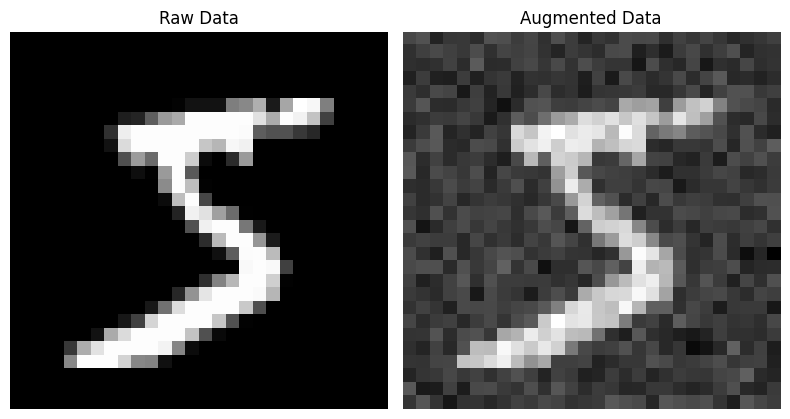

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

axes[0].imshow(x_train[0], cmap='gray')
axes[0].axis('off')
axes[0].set_title("Raw Data")

axes[1].imshow(x_train_augmented[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title("Augmented Data")

plt.tight_layout()
plt.show()

# Normal Model

In [7]:
normal_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [8]:
normal_model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [9]:
normal_model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2201 - accuracy: 0.9343
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0924 - accuracy: 0.9712
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0664 - accuracy: 0.9789
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0482 - accuracy: 0.9847
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0409 - accuracy: 0.9866
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0330 - accuracy: 0.9891
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0257 - accuracy: 0.9912
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0247 - accuracy: 0.9921
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0211 - accuracy: 0.9930
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.018

# Augmented Model

In [10]:
augmented_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [11]:
augmented_model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [12]:
augmented_model.fit(x_train_augmented, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2357 - accuracy: 0.9286
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0923 - accuracy: 0.9713
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0576 - accuracy: 0.9818
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0365 - accuracy: 0.9881
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0278 - accuracy: 0.9904
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0212 - accuracy: 0.9930
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0176 - accuracy: 0.9942
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0174 - accuracy: 0.9942
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0156 - accuracy: 0.9950
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.012

# Fast Gradient Method Attack

In [14]:
art_model = TensorFlowV2Classifier(
    model=normal_model, 
    loss_object=CategoricalCrossentropy(from_logits=True), 
    nb_classes=10, 
    input_shape=(28, 28), 
    clip_values=(0, 1)
)

In [15]:
fgsm = FastGradientMethod(estimator=art_model, eps=0.1)

In [16]:
adv_test = fgsm.generate(x=x_test)

# Results

In [17]:
y_test = np.argmax(y_test, axis=1)

In [18]:
safe_preds = np.argmax(normal_model.predict(adv_test), axis=1)

313/313 [==============================] - 1s 2ms/step


In [19]:
augmented_preds = np.argmax(augmented_model.predict(adv_test), axis=1)

313/313 [==============================] - 0s 1ms/step


In [20]:
print("Safe Model Accuracy Score on FSM Data:", accuracy_score(y_test, safe_preds))
print("Augmented Model Accuracy Score on FSM Data:", accuracy_score(y_test, augmented_preds))

Safe Model Accuracy Score on FSM Data: 0.3368
Augmented Model Accuracy Score on FSM Data: 0.737
